In [17]:
using Revise

using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using ITensors

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true

true

In [2]:
a, b = 0, 3
A = 1
B = 1e-2
nquantics = 62
ndiscretization = 2^nquantics

xvals(i) = a + (b - a) * i / ndiscretization
yvals(i) = a + (b - a) * i / ndiscretization

step = div(ndiscretization, 1923)
nadd = 1

tolerance = 1e-8

function f(q)
    qx, qy = split_dimensions(q, 2)
    x = xvals(quantics_to_index(qx)[1])
    y = yvals(quantics_to_index(qy)[1])
    return exp(-x^2 - y^2 / A^2) * cos(2pi * x / B) * cos(2pi * y / B)
end

struct cachedfunc{ValueType}
    f::Function
    d::Dict{Vector{Int}, ValueType}
    
    function cachedfunc(::Type{ValueType}, f::Function) where ValueType
        new{ValueType}(f, Dict())
    end
end
    
function (cf::cachedfunc{ValueType})(x::Vector{Int})::ValueType where {ValueType}
    return get!(cf.d, x) do
        cf.f(x)
    end
end
    
Base.broadcastable(x::cachedfunc) = Ref(x)
    
cf = cachedfunc(Float64, f)

#cf = TCI.CachedFunction{Float64}(f, fill(2, nquantics));
#plot(xvals, [f(index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization])
getq(i, j) = merge_dimensions(index_to_quantics(i, nquantics), index_to_quantics(j, nquantics))


getq (generic function with 1 method)

In [3]:
#firstpivot = TCI.optfirstpivot(f, fill(2, 2nquantics), [1, 1, fill(2, 2nquantics-2)...])

#firstpivot = TCI.optfirstpivot(f, fill(2, 2nquantics))
#firstpivot = getq(div(ndiscretization, 2), div(ndiscretization, 2))
#firstpivot = fill(2, 2nquantics)

additionalpivots = Vector{Int}[rand(1:2, nquantics) for _ in 1:nadd]

time = @elapsed tci, ranks, errors = TCI.crossinterpolate(
    Float64,
    f,
    fill(4, nquantics),
#    firstpivot,
    tolerance=tolerance,
    #additionalpivots=additionalpivots
)

println("Elapsed: $time s for $(maximum(ranks)) iterations.")

Elapsed: 7.981974584 s for 116 iterations.


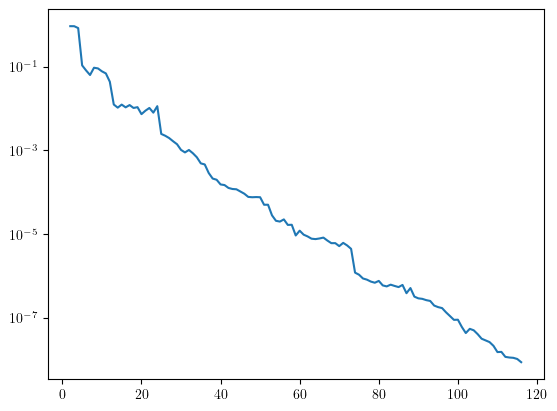

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x16ed7a1c0>

In [18]:
semilogy(ranks, errors)

In [5]:
mps = qtt_to_mps(TCI.tensortrain(tci))

jot(i) = div(i, 10) + 1
    
tcieval = [
    evaluate_mps(mps, siteinds(mps), getq(i, jot(i)))
    for i in 1:step:ndiscretization]
original = [f(getq(i, jot(i))) for i in 1:step:ndiscretization]
difference = original .- tcieval;

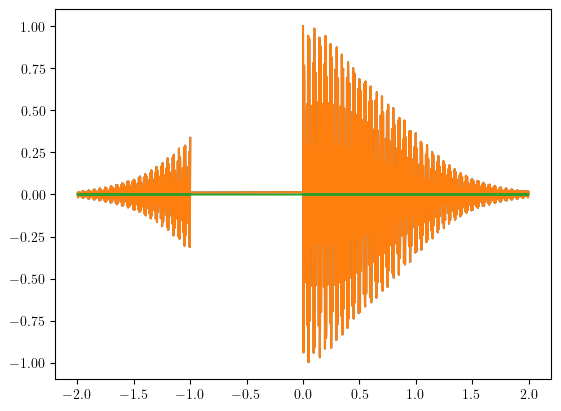

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x16b82e1f0>

In [19]:
xstep = xvals.(1:step:ndiscretization)

plot(xstep, original)
plot(xstep, tcieval)
plot(xstep, difference)

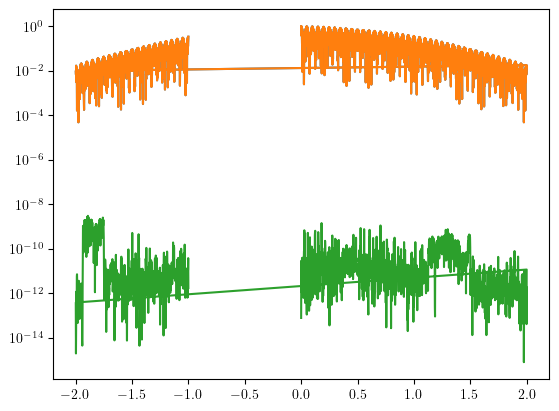

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x16c64f310>

In [20]:
semilogy(xstep, abs.(original))
semilogy(xstep, abs.(tcieval))
semilogy(xstep, abs.(difference))

In [21]:
insetinterval = [0.0, 10 * B]

@show ib = [round(Int, (i - a) * ndiscretization / (b - a)) for i in insetinterval]
    
insetstep = div(ib[2] - ib[1], 256)
inseteval = [evaluate_mps(mps, siteinds(mps), getq(i, jot(i))) for i in ib[1]:insetstep:ib[2]]
insetorig = [f(getq(i, jot(i))) for i in ib[1]:insetstep:ib[2]]
insetdiff = inseteval .- insetorig

ib = [round(Int, ((i - a) * ndiscretization) / (b - a)) for i = insetinterval] = [0, 153722867280912928]


257-element Vector{Float64}:
 -3.5860203695392556e-14
  1.0913492332065289e-12
  4.602984660095899e-13
 -1.596056620201125e-12
  5.119460411151522e-12
 -1.0814904527478575e-11
 -1.2354270384484778e-11
  2.286273670382144e-10
 -2.1778856496013077e-11
  2.4372837081898524e-11
  2.372657625926422e-12
  9.567124870102361e-12
  9.787615162792918e-11
  ⋮
  6.434408561517557e-12
  2.041522506601723e-11
  1.0450973420006449e-11
  1.1124767773651456e-11
  1.4013928906209117e-11
 -3.73799324826507e-11
 -3.6020297855543504e-11
 -5.917355494489129e-11
 -1.9296897413312308e-11
 -2.5299295991487725e-10
  6.5707439489415265e-12
  9.438005932338456e-12

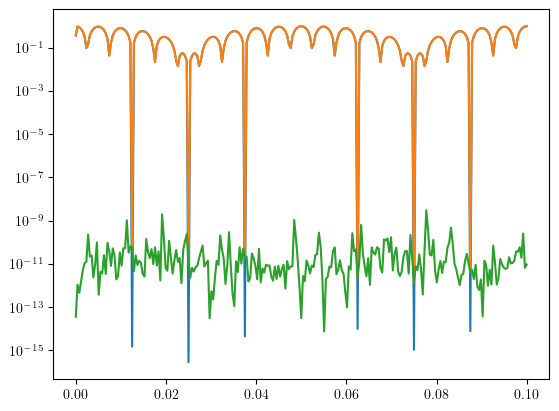

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x16c684100>

In [22]:
insetx = xvals.(ib[1]:insetstep:ib[2])

semilogy(insetx, abs.(insetorig))
semilogy(insetx, abs.(inseteval))
semilogy(insetx, abs.(insetdiff))

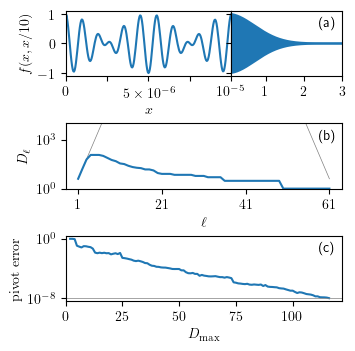

In [40]:
# --- Calculate layout ---
ptperinch = 72

figurew, figureh = (246, 246)
padw, padh = (5, 3)

xlabelh = 34
ylabelw = 42

axw = figurew - padw - ylabelw
axh = (figureh - padh) / 3 - xlabelh

zoomaxw = 0.6 * axw
overvieww = axw - zoomaxw

axbottoms = [(i * axh + (i + 1) * xlabelh) for i in 0:2]
units = [figurew, figureh, figurew, figureh]

# --- end ---

fig = figure(figsize=(figurew/ptperinch, figureh/ptperinch))
    
zoomax = fig.add_axes((ylabelw, axbottoms[3], zoomaxw, axh) ./ units)
overviewax = fig.add_axes((ylabelw + zoomaxw, axbottoms[3], overvieww, axh) ./ units)
bonddimax = fig.add_axes((ylabelw, axbottoms[2], axw, axh) ./ units)
errorax = fig.add_axes((ylabelw, axbottoms[1], axw, axh) ./ units)

insetx = xvals.(ib[1]:insetstep:ib[2])
zoomax.plot(insetx, inseteval)

#zoomax.plot(xvals[ib[1]:insetstep:ib[2]], insetorig, "--")
#zoomax.plot(xvals[ib[1]:insetstep:ib[2]], insetdiff)

zoomax.set_xlabel(L"$x$")
#zoomax.annotate(
#    L"$x$",
#    xy=(0.5 * axw, -20),
#    xycoords="axes points"
#)

zoomax.set_ylabel(L"$f(x, x/10)$")
zoomax.set_xlim(insetinterval)
zoomax.set_xticks(range(insetinterval..., length=5), [L"$0$", "", L"$5\times10^{-6}$", "", L"10^{-5}"])

xplot = range(0, 3, length=500)
gauss = exp.(-xplot.^2 .- (0.1 .* xplot).^2 ./ A)
overviewax.fill_between(xplot, -gauss, gauss)
overviewax.plot(xplot, -gauss, "tab:blue")
overviewax.plot(xplot, gauss, "tab:blue")

#zoomax.plot(insetx, -gauss.(insetx), "tab:orange")
#zoomax.plot(insetx, gauss.(insetx), "tab:orange")

#overviewax.plot(xvals[1:step:end], tcieval)
overviewax.set_yticks([-1, 0, 1], ["", "", ""])
overviewax.set_xlim(insetinterval[2], b)
overviewax.set_xticks([1, 2, 3], [L"$1$", L"$2$", L"$3$"])

faxlim = 1.1
zoomax.set_ylim(-faxlim, faxlim)
overviewax.set_ylim(-faxlim, faxlim)

bonddimax.semilogy(1:nquantics-1, [min(4^Float64(x), 4^Float64(nquantics-x)) for x in 1:nquantics-1], color="gray", linewidth=0.5)
bonddimax.semilogy(1:nquantics-1, TCI.linkdims(tci))
bonddimax.set_xticks(1:20:nquantics-1)
bonddimax.set_xlabel(L"$\ell$")
bonddimax.set_ylabel(L"$D_\ell$")
bonddimax.set_ylim(1, 1e4)

errorax.semilogy(ranks, errors)
errorax.set_xlim(0)
errorax.set_xlabel(L"$D_{\mathrm{max}}$")
errorax.set_ylabel(L"\mathrm{pivot~error}")
errorax.axhline(tolerance, color="gray", linewidth=0.5)
errorax.set_yticks([1e-8, 1], [L"$10^{-8}$", L"$10^0$"])

for (ax, label) in zip([overviewax, bonddimax, errorax], "abc")
    ax.annotate(
        "($label)",
        xy=(1, 1),
        xycoords="axes fraction",
        horizontalalignment="right",
        verticalalignment="top",
        xytext=(-4, -4),
        textcoords="offset points"
    );
end

fig.savefig("twod_cosine_gaussian.pdf")